**Mount from Google drive**

In [0]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


**Check for GPU**

In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10160519308281190211, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14866664249390565754
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12573730299510525928
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15701463552
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2493297777497726975
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

**Navigate to mounted project from Google Drive**

In [0]:
cd "/content/drive/My Drive/ex2_201641164_304862675/"

/content/drive/My Drive/ex2_201641164_304862675


In [0]:
import tensorflow as tf
import os
import collections
import numpy as np
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense,  Embedding, Dropout, TimeDistributed, Activation
from keras.layers import LSTM, GRU
from keras.optimizers import Adam, SGD
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback
from keras.constraints import max_norm
from keras.initializers import RandomUniform
from matplotlib import pyplot as plt

Using TensorFlow backend.


**Data Parsing**

In [0]:
def read_words(filename):
    """
    reads file
    :param filename: str, location of file
    :return: lst
    """
    with tf.io.gfile.GFile(filename, "r") as f:
        return f.read().replace("\n", "<eos>").split()


def build_vocab(filename):
    """
    creates mapping from word to integer
    :param filename: str, location of file
    :return: dict <key: str, value: int>
    """
    lst = read_words(filename)
    counter = collections.Counter(lst)
    count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))
    words, _ = list(zip(*count_pairs))
    word_to_idx = dict(zip(words, range(len(words))))
    return word_to_idx


def file_to_word_ids(filename, word_to_id):
    """
    reads file and converts each word in the file to the matching index,
    and makes sure there is no words in the files that are not in the mapping
    :param filename: str, location of file
    :param word_to_id: dict <key: str, value: int>
    :return:list
    """
    data = read_words(filename)
    return [word_to_id[word] for word in data if word in word_to_id]



def load_data():
    """
    reads train , validation and test files, creates mapping word--> idx,
    replaces the words in the files with the matching indexes from the mapping,
    creates the reverse mapping idx --> word, adds vocab size
    :return: list
    :return: list
    :return: list
    :return: int
    :return dict <key: int, value: str>
    """
    # get the data paths
    train_path = os.path.join(DATA_PATH, "ptb.train.txt")
    valid_path = os.path.join(DATA_PATH, "ptb.valid.txt")
    test_path = os.path.join(DATA_PATH, "ptb.test.txt")

    # build the complete vocabulary, then convert text data to list of integers
    word_to_idx = build_vocab(train_path)
    train_data = file_to_word_ids(train_path, word_to_idx)
    valid_data = file_to_word_ids(valid_path, word_to_idx)
    test_data = file_to_word_ids(test_path, word_to_idx)
    v = len(word_to_idx)
    idx_to_word = dict(zip(word_to_idx.values(), word_to_idx.keys()))

    return train_data, valid_data, test_data, v, idx_to_word


**Data Generator**

In [0]:
class KerasBatchGenerator(object):


    def __init__(self, data, num_steps, batch_size, v):
        """

        :param data: list of integers
        :param num_steps: int , represents time dimension
        :param batch_size: int
        :param v: int , voacb size
       
        """
        self.data = data
        self.num_steps = num_steps
        self.batch_size = batch_size
        self.v = v
        # this will track the progress of the batches sequentially through the
        # data set - once the data reaches the end of the data set it will reset
        # back to zero
        self.current_idx = 0

    def generate(self):
        """

        :yields: iterator : (x np.array [batch_size, num_steps], y np.array [batch_size, vocab_size])
        """


        x = np.zeros((self.batch_size, self.num_steps)) #input fed to Embedding() layer must be [batch_size, time_dim]. After Embedding it will become 3D for LSTM
        y = np.zeros((self.batch_size, self.num_steps, self.v)) #we  output the whole sequence so we can learn quicker
        while True:
            for i in range(self.batch_size): # i is a row in our data
                if self.current_idx + self.num_steps >= len(self.data):
                    # reset the index back to the start of the data set if we pass the end of the list
                    self.current_idx = 0
                x[i, :] = self.data[self.current_idx:self.current_idx + self.num_steps] #get [X(t-n), X(t-n+1), ... X(t-1), X(t)]
                temp_y = self.data[self.current_idx + 1:self.current_idx + self.num_steps + 1] # get [X(t-n+1), X(t-n+2)... X(t), X(t+1)]
                # convert all of temp_y into a one hot representation
                y[i, :, :] = to_categorical(temp_y, num_classes=self.v)
                self.current_idx += self.num_steps 


            yield x, y


**Some Utils**

In [0]:
def check_data_gen(data,v):
    """
    Creates one iteration from the generator
    :param data: list of integers
    :param v: int , voacb size
    :return:
    """
    test_gen = KerasBatchGenerator(data, num_steps=5, batch_size=10, v=v)
    print('hi the original data (first 50 indices ) is ')
    print(data[0:50])
    x, y = next(test_gen.generate())
    print(x.shape, y.shape)
    print('this is a batch of size : ', 10, ' and time dim of ', 5)
    print('X is ')
    print(x)
    print('y is ')
    print(y)
    print(' argmax of y is ')
    print(np.argmax(y, axis=2))

In [0]:
def plot_results(loss, val_loss,  epochs, suffix=None):
    """ Saves plot of convergence graph

    :param loss: lst
    :param val_loss: lst
    :param epochs: int
    :param suffix: str
    :return:
    """

    num_epochs = np.arange(1,epochs+1)
    plt.figure(dpi=200)
    plt.style.use('ggplot')
    plt.plot(num_epochs, loss, label='train_perplexity', c='red')
    plt.plot(num_epochs, val_loss, label='test_perplexity', c='green')
    plt.title('Convergence Graph- {}'.format(suffix))
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.legend()
    plt.savefig('./plots/Convergence Graph- {}.png'.format(suffix))

In [0]:
def load_pretrained_model(path_to_model):
  """ Loads pretrained model and calculated preplexity on hold out test data.
  :param path_to_model: str
  :return:
  """

  model = load_model(path_to_model)
  test_results = model.evaluate_generator(test_data_generator.generate(), steps= len(test_data)//(batch_size*num_steps))
  print('Perplexity on Test Set: {}'.format( np.power(2,test_results[0])))
  print('Crossentropy on Test Set: {}'.format((test_results[0])))


 



To start training the model run the following cells. 
# Warning: this might take a while, to load a pretrained model skip to the final secion

---



**Change USE_GRU and USE_DROPOUT to generate 4 differnet models**

In [0]:
DATA_PATH = './data'
MODEL_PATH = './pretrained_models'
USE_GRU = True
USE_DROPOUT = False

In [0]:
train_data, valid_data, test_data, V, idx_to_word = load_data()


In [0]:
ppe_train = []
ppe_val = []
seed = 42
num_steps = 35
batch_size =64
embedding_dim = 200 
hidden_units = 200 
dropout = 0.5 if USE_DROPOUT else 0.0
nb_epoch = 39 
#check_data_gen(train_data, V)
train_data_generator = KerasBatchGenerator(train_data, num_steps, batch_size, V)
valid_data_generator = KerasBatchGenerator(valid_data, num_steps, batch_size, V)
test_data_generator = KerasBatchGenerator(test_data, num_steps, batch_size, V)

In [19]:
my_init = RandomUniform(minval=-0.05, maxval=0.05, seed=seed)

model = Sequential()
model.add(Embedding(V, embedding_dim, batch_input_shape=(batch_size,num_steps) , input_length=num_steps))
if USE_GRU:
    model.add(GRU(units=hidden_units, batch_input_shape=(batch_size, num_steps, embedding_dim), dropout=dropout,
                   kernel_constraint=max_norm(5.), recurrent_constraint=max_norm(5.), bias_constraint=max_norm(5.),
                   kernel_initializer=my_init, recurrent_initializer=my_init, bias_initializer='zeros',
                   stateful=True, return_sequences=True))
    model.add(GRU(units=hidden_units, batch_input_shape=(batch_size, num_steps, embedding_dim), dropout=dropout,
                   kernel_constraint=max_norm(5.), recurrent_constraint=max_norm(5.), bias_constraint=max_norm(5.),
                   kernel_initializer=my_init, recurrent_initializer=my_init, bias_initializer='zeros',
                   stateful=True, return_sequences=True))
else:
    model.add(LSTM(units = hidden_units, batch_input_shape=(batch_size,num_steps, embedding_dim), dropout = dropout,
                   kernel_constraint=max_norm(5.), recurrent_constraint=max_norm(5.), bias_constraint=max_norm(5.),
                   kernel_initializer=my_init, recurrent_initializer=my_init, bias_initializer='zeros',
                   stateful=True, return_sequences=True))
    model.add(LSTM(units = hidden_units, batch_input_shape=(batch_size,num_steps, embedding_dim), dropout = dropout,
                   kernel_constraint=max_norm(5.), recurrent_constraint=max_norm(5.), bias_constraint=max_norm(5.),
                   kernel_initializer=my_init, recurrent_initializer=my_init, bias_initializer='zeros',
                   stateful=True, return_sequences=True))
  
model.add(Dropout(dropout)) #third and final drop out. If there are L layers of LSTM, there are L+1 Dropouts
model.add(TimeDistributed(Dense(V)))
model.add(Activation('softmax'))



print(model.summary())
base_lr = 0.5
for i in range(nb_epoch):  
    decay = 1.2 if i>=6 else 1
    lr = base_lr/decay
    optimizer = SGD(lr=lr)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer,  metrics=['categorical_accuracy'])
    #categorical accuracy, example in 3 class category prediction:
    # y_ture = [[1,0,0],[0,1,0]] y_pred = [[0.5,0.3,0.2], [0.8,0.2,0.2]]
    # then we have one correct pred and one incorrect. resulting in categorical acc= 0.5

    model.fit_generator(train_data_generator.generate(),
                        steps_per_epoch= len(train_data)//(batch_size*num_steps),
                        epochs =1,
                        validation_data=valid_data_generator.generate(),
                        validation_steps=len(valid_data)//(batch_size*num_steps), verbose = 1)
    train_results = model.evaluate_generator(train_data_generator.generate(), steps= len(train_data)//(batch_size*num_steps)) 
    test_results = model.evaluate_generator(valid_data_generator.generate(), steps= len(valid_data)//(batch_size*num_steps))

    perplexity_train = np.power(2,train_results[0]) # PPE = exp (categorical_crossentropy)
    perplexity_val = np.power(2,test_results[0])
    print('After Epoch : {}, PPE train : {}, PPE val : {}'.format(i+1, perplexity_train, perplexity_val))
    ppe_train.append(perplexity_train)
    ppe_val.append(perplexity_val)
    model.reset_states()

print('evaluating on Test set')
test_results = model.evaluate_generator(test_data_generator.generate(), steps= len(test_data)//(batch_size*num_steps))
print('Perplexity on Test Set: {}'.format( np.power(2,test_results[0])))
print('Crossentropy on Test Set: {}'.format((test_results[0])))

model.save(os.path.join(MODEL_PATH,"model_use_gru:{}_use_dropout:{}.hdf5".format(USE_GRU, USE_DROPOUT)))


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (64, 35, 200)             2000000   
_________________________________________________________________
gru_1 (GRU)                  (64, 35, 200)             240600    
_________________________________________________________________
gru_2 (GRU)                  (64, 35, 200)             240600    
_________________________________________________________________
dropout_2 (Dropout)          (64, 35, 200)             0         
_________________________________________________________________
time_distributed_2 (TimeDist (64, 35, 10000)           2010000   
_________________________________________________________________
activation_2 (Activation)    (64, 35, 10000)           0         
Total params: 4,491,200
Trainable params: 4,491,200
Non-trainable params: 0
____________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
414/414 [==============================] - 73s 177ms/step - loss: 7.5908 - categorical_accuracy: 0.0497 - val_loss: 7.6057 - val_categorical_accuracy: 0.0564
After Epoch : 1, PPE train : 184.87239020162662, PPE val : 178.62103666006973
Epoch 1/1
414/414 [==============================] - 78s 189ms/step - loss: 7.5899 - categorical_accuracy: 0.0489 - val_loss: 8.1954 - val_categorical_accuracy: 0.0556
After Epoch : 2, PPE train : 163.76384170256702, PPE val : 194.60827479834285
Epoch 1/1
414/414 [==============================] - 75s 181ms/step - loss: 7.5684 - categorical_accuracy: 0.0498 - val_loss: 7.2011 - val_categorical_accuracy: 0.0558
After Epoch : 3, PPE train : 208.07738622102914, PPE val : 220.19116924011158
Epoch 1/1
414/414 [==============================] - 76s 184ms/step - loss: 7.5600 - categorical_accuracy: 0.0507 - val_loss: 7.5667 - val_categorical_accuracy: 0.0560
After Epoch : 4, PPE train : 163.51234469051852, PPE val : 195.7567032618193
Epoch 1/1
414/414

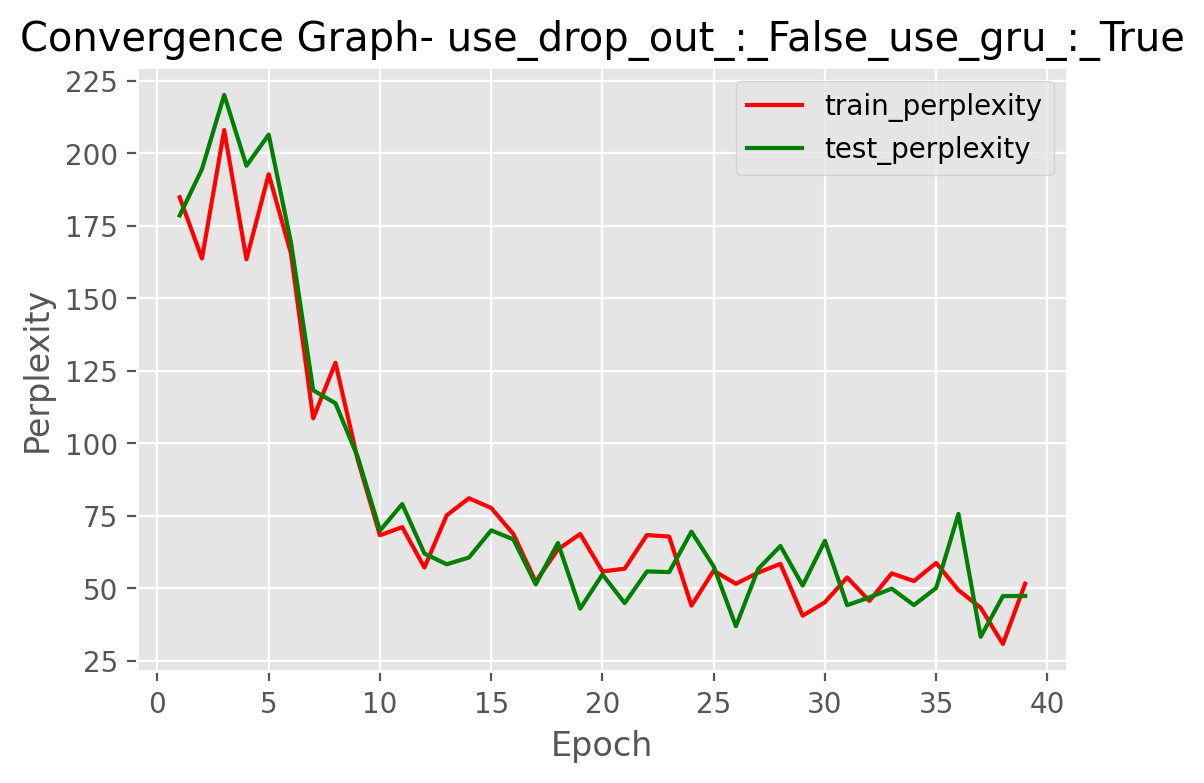

In [20]:
plot_results(loss=ppe_train, val_loss=ppe_val, epochs=nb_epoch, suffix='use_drop_out_:_{}_use_gru_:_{}'.format(USE_DROPOUT, USE_GRU))

# Load Pretrained models 
for **GRU** model **without** dropout set type = 1

for **GRU** model **with** drop out set type = 2

for **LSTM** model **without** dropout set type =3 

for **LSTM** model with drop out set type =4

In [0]:
TYPE = 4

In [0]:
assert TYPE in (1,2,3,4)

In [0]:
model_mapping = {1: './pretrained_models/model_use_gru:True_use_dropout:False.hdf5',
                 2: './pretrained_models/model_use_gru:True_use_dropout:True.hdf5',
                 3: './pretrained_models/model_use_gru:False_use_dropout:False.hdf5',
                 4: './pretrained_models/model_use_gru:False_use_dropout:True.hdf5'}

In [0]:
path_to_model = model_mapping[TYPE]

In [74]:

load_pretrained_model(path_to_model)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Perplexity on Test Set: 68.99791828512193
Crossentropy on Test Set: 6.108480930328369
